In [88]:
import numpy as np
import os
import pandas as pd
import re
import requests
import kagglehub
import sys
import matplotlib.pyplot as plt
import pickle
from dataclasses import dataclass

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Machine Learning Project

by Andon Gorchov (@thunderman913)

# Data Tidying

In [89]:
path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

earnings_path = f"{path}\\stocks_latest\\earnings_latest.csv"
stock_prices_path = f"{path}\\stocks_latest\\stock_prices_latest.csv"

In [90]:
# Function to get the price X days ago
def get_price_x_days_ago(df, days):
    return df['close'].shift(days)

def get_peak_price_and_days_ago(df):
    df['peak_price'] = df['close'].rolling(window=90, min_periods=1).max()
    peak_day_index = df['close'].rolling(window=90, min_periods=1).apply(lambda x: (len(x) - 1 - x.argmax()), raw=False)
    df['peak_days_ago'] = peak_day_index.fillna(0).astype(int)  # Fill NaN for rows that don't have enough data
    return df

def process_ticker_data(df):
    # Add columns for prices X days ago
    for days in [1,2,3,4,5, 10, 15, 30, 60, 90]:
        df[f'price_{days}_days_ago'] = df.groupby('ticker')['close'].shift(days)
        df[f'volume_{days}_days_ago'] = df.groupby('ticker')['volume'].shift(days)

    df = df.groupby('ticker', group_keys=False).apply(get_peak_price_and_days_ago)

    return df

In [91]:
# Adding earnings data to stock_data_tidy based on the nearest previous date
def add_earnings_data(stock_data, earnings):
    merged_df = pd.merge_asof(
        stock_data.sort_values(by='date'),
        earnings.sort_values(by='earnings_date'),
        by='ticker',
        left_on='date',
        right_on='earnings_date',
        direction='backward'
    )
    
    # Ensure non-trading days are adjusted properly
    merged_df = merged_df.sort_values(by=['ticker', 'date'])

    merged_df = pd.merge_asof(
        merged_df.sort_values(by='date'),
        earnings[['ticker', 'earnings_date']].sort_values(by='earnings_date'),
        by='ticker',
        left_on='date',
        right_on='earnings_date',
        direction='forward',
        suffixes=('', '_next'),
        allow_exact_matches=False
    )
    
    # Remove NA earnings dates
    merged_df = merged_df.drop(merged_df[(merged_df.earnings_date.isna()) | (merged_df.earnings_date_next.isna())].index)
    merged_df['days_till_report'] = (merged_df['earnings_date_next'] - merged_df['date']).dt.days
    merged_df['days_since_report'] = (merged_df['date'] - merged_df['earnings_date']).dt.days

    return merged_df

In [92]:
def getEarningsData():
    earnings_data_file = './pickles/earnings_data_processed.pkl'

    if os.path.exists(earnings_data_file):
        return pd.read_pickle(earnings_data_file)

    earnings_data = pd.read_csv(earnings_path)

    earnings_data_tidy = earnings_data
    earnings_data_tidy.date = pd.to_datetime(earnings_data_tidy.date)

    earnings_data_tidy = earnings_data_tidy.rename(columns={'symbol': 'ticker'})

    earnings_data_tidy = earnings_data_tidy.drop(earnings_data_tidy[(earnings_data_tidy.eps.isna()) | (earnings_data_tidy.eps_est.isna())].index)
    earnings_data_tidy = earnings_data_tidy.drop(columns=['qtr'])

    earnings_data_tidy = earnings_data_tidy.rename(columns={'date': 'earnings_date'})

    earnings_data_tidy['release_time'] = earnings_data_tidy.groupby('ticker')['release_time'].ffill().bfill()

    earnings_data_tidy.to_pickle(earnings_data_file)

    return earnings_data_tidy

In [93]:
stock_data_file = './pickles/stock_data_processed.pkl'

In [94]:
def getTidiedStockData():
    # Check if the file exists
    if os.path.exists(stock_data_file):
        return pd.read_pickle(stock_data_file)

    # Read the basic data and some tidying
    stock_data = pd.read_csv(stock_prices_path)
    stock_data_tidy = stock_data

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'])

    earnings_data_tidy = getEarningsData()

    stock_data_tidy = stock_data_tidy[(stock_data_tidy['date'] > (earnings_data_tidy['earnings_date'].min() - pd.Timedelta(days=100)))
                                    | (stock_data_tidy['date'] < earnings_data_tidy['earnings_date'].max() + pd.Timedelta(days=5))]

    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    stock_data_tidy = process_ticker_data(stock_data_tidy)

    stock_data_tidy = stock_data_tidy[stock_data_tidy.price_90_days_ago.isna() == False]
    
    stock_data_tidy = add_earnings_data(stock_data_tidy, earnings_data_tidy)

    # Encode labels for the forest regressor
    le = LabelEncoder()
    stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])
    
    stock_data_tidy.to_pickle(stock_data_file)

    return stock_data_tidy

In [95]:
stock_data_tidy = getTidiedStockData()

In [96]:
stock_data_tidy[['ticker','date', 'earnings_date', 'earnings_date_next', 'days_till_report', 'days_since_report']]

,ticker,date,earnings_date,earnings_date_next,days_till_report,days_since_report
11137135,C,2012-07-16,2012-07-16,2012-10-15,91,0
11138878,CSX,2012-07-17,2012-07-17,2012-10-16,91,0
11138900,FIS,2012-07-17,2012-07-17,2012-11-05,111,0
11139425,WYNN,2012-07-17,2012-07-17,2012-10-24,99,0
11140712,C,2012-07-17,2012-07-16,2012-10-15,90,1
...,...,...,...,...,...,...
23691461,ADXS,2021-06-10,2020-09-10,2021-06-14,4,273
23692035,RFIL,2021-06-10,2021-03-11,2021-06-14,4,91
23693010,ADXS,2021-06-11,2020-09-10,2021-06-14,3,274
23693122,RFIL,2021-06-11,2021-03-11,2021-06-14,3,92


We remove data with more than 120 days on both next and previous report, since that is useless data for our case

In [97]:
stock_data_tidy = stock_data_tidy.drop(stock_data_tidy[(stock_data_tidy.days_till_report > 120) & (stock_data_tidy.days_since_report > 120)].index)
# Remove useless columns
stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close_adjusted', 'volume'])

# Forest Regressor

In [98]:
features = [
    'ticker_encoded', 'peak_price', 'peak_days_ago', 'price_1_days_ago', 'volume_1_days_ago',
    'price_2_days_ago', 'volume_2_days_ago', 'price_3_days_ago', 'volume_3_days_ago',
    'price_4_days_ago', 'volume_4_days_ago', 'price_5_days_ago', 'volume_5_days_ago',
    'price_10_days_ago', 'volume_10_days_ago', 'price_15_days_ago', 'volume_15_days_ago',
    'price_30_days_ago', 'volume_30_days_ago', 'price_60_days_ago', 'volume_60_days_ago',
    'price_90_days_ago', 'volume_90_days_ago', 'eps_est', 'eps', 'days_till_report', 'days_since_report'
]

target = 'close'

In [99]:
@dataclass
class PreparedData:
    X_train: any
    X_test: any
    y_train: any
    y_test: any
    X_final_test: any
    y_final_test: any
    scaler_X: any = None
    scaler_y: any = None

def prepare_data(data, features, target, scale_output, frac=0.05):
    stock_data_tidy_train = data.sample(frac=frac, random_state=42)
    
    X = stock_data_tidy_train[features]
    y = stock_data_tidy_train[target]

    scaler_X = StandardScaler()
    X = scaler_X.fit_transform(X)
    
    if scale_output:    
        scaler_y = StandardScaler()
        y = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()
    else:
        scaler_X, scaler_y = None, None
    
    X_main, X_final_test, y_main, y_final_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=0.2, random_state=42)
    
    return PreparedData(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        X_final_test=X_final_test,
        y_final_test=y_final_test,
        scaler_X=scaler_X,
        scaler_y=scaler_y
    )

In [100]:
forest_grid_search_data = prepare_data(stock_data_tidy, features, target, False, 0.005)

In [101]:
forest_grid_search_path = './pickles/forest_grid_search.pkl'

In [102]:
def getGridSearch():
    if os.path.exists(forest_grid_search_path):
        return pd.read_pickle(forest_grid_search_path)

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    forest_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
    forest_grid_search.fit(forest_grid_search_data.X_train, forest_grid_search_data.y_train)

    best_params = forest_grid_search.best_params_
    print(f"Best Parameters: {best_params}")

    with open(forest_grid_search_path, 'wb') as model_file:
        pickle.dump(forest_grid_search, model_file)

    return forest_grid_search

In [ ]:
forest_grid_search = getGridSearch()

Fitting 3 folds for each of 81 candidates, totalling 243 fits


Mean Squared Error for n_estimators=1: 213.62836482477752
Mean Squared Error for n_estimators=20: 20.845772824635056
Mean Squared Error for n_estimators=50: 25.88730843224147
Mean Squared Error for n_estimators=75: 22.046313879624797
Mean Squared Error for n_estimators=100: 18.33769813044673
Mean Squared Error for n_estimators=150: 16.960019354668475
Mean Squared Error for n_estimators=200: 21.841726019754258


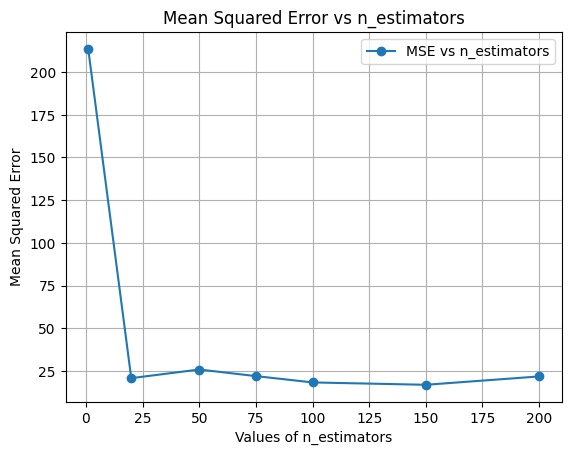

Mean Squared Error for max_depth=1: 9953.354213901817


KeyboardInterrupt: 

In [ ]:
def evaluate_param(param_name, param_values):
    mse_values = []
    for value in param_values:
        model_params = forest_grid_search.best_params_
        model_params[param_name] = value
        model = RandomForestRegressor(**model_params, random_state=42)
        model.fit(forest_grid_search_data.X_train, forest_grid_search_data.y_train)
        y_pred = model.predict(forest_grid_search_data.X_test)
        mse = mean_squared_error(forest_grid_search_data.y_test, y_pred)
        mse_values.append(mse)
        print(f"Mean Squared Error for {param_name}={value}: {mse}")
    
    # Plot MSE for the parameter
    plt.figure()
    plt.plot(param_values, mse_values, marker='o', linestyle='-', label=f'MSE vs {param_name}')
    plt.xlabel(f'Values of {param_name}')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Mean Squared Error vs {param_name}')
    plt.grid(True)
    plt.legend()
    plt.show()

n_estimators_values = [1, 20, 50, 75, 100, 150, 200]
evaluate_param('n_estimators', n_estimators_values)

max_depth_values = [1, 5, 10, 20, 40]
evaluate_param('max_depth', max_depth_values)

min_samples_split_values = [2, 5, 10, 15, 20]
evaluate_param('min_samples_split', min_samples_split_values)

min_samples_leaf_values = [1, 2, 4, 8, 12, 20]
evaluate_param('min_samples_leaf', min_samples_leaf_values)

The best params seem to be {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}. Let's train the model with them

In [ ]:
forest_model_data = prepare_data(stock_data_tidy, features, target, False, 1)

In [ ]:
forest_model = RandomForestRegressor(n_estimators=20, max_depth=20,min_samples_split=2, min_samples_leaf=1, random_state=42)

# Fit the model to your training data
forest_model.fit(forest_model_data.X_train, forest_model_data.y_train)

KeyboardInterrupt: 

C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


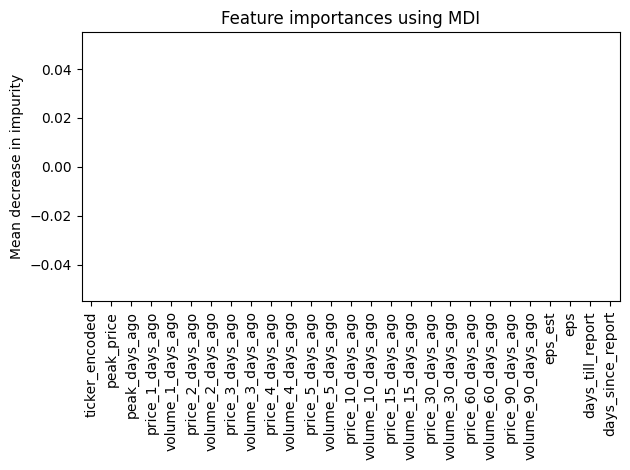

In [ ]:
# TODO investigate the importances on the actual result
std = np.std([tree.feature_importances_ for tree in forest_model.estimators_], axis=0)

importances = forest_model.feature_importances_
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Linear Regression

Linear Regression TODO check if all good and improve :)

In [ ]:
linear_regression_data = prepare_data(stock_data_tidy, features, target, False, 1)

Training Score: 0.9999291653900366
Mean Squared Error: 558.050724454366


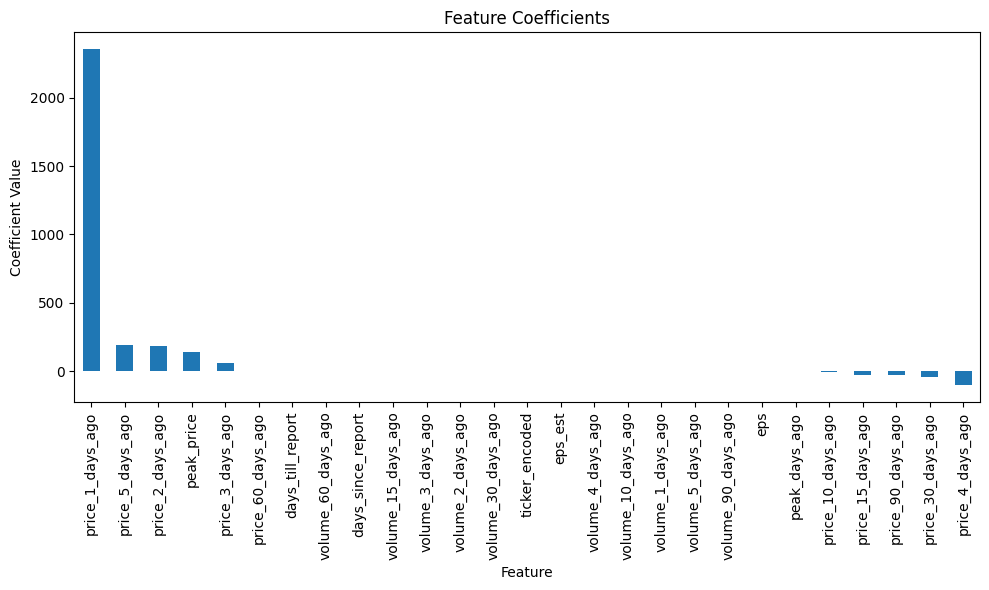

In [ ]:
linear_model = LinearRegression()
linear_model.fit(linear_regression_data.X_train, linear_regression_data.y_train)

# Score the model on the training data
train_score = linear_model.score(linear_regression_data.X_train, linear_regression_data.y_train)
print(f"Training Score: {train_score}")

# Make predictions on the test set
y_pred = linear_model.predict(linear_regression_data.X_test)

# Calculate and print the mean squared error
mse = np.mean((linear_regression_data.y_test - y_pred) ** 2)
print(f"Mean Squared Error: {mse}")

# Linear regression does not provide feature importances in the same way as RandomForest
# Instead, we can look at the coefficients
coefficients = pd.Series(linear_model.coef_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar')
plt.title('Feature Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
train_score = linear_model.score(linear_regression_data.X_final_test, linear_regression_data.y_final_test)
print(f"Training Score: {train_score}")

Training Score: 0.9999200251178422


In [ ]:
# Test a certain row
linear_regression_data.X_final_test[1].__len__()
predicted_close = linear_model.predict(linear_regression_data.X_final_test[-4].reshape(1,-1))
predicted_close

predicted_close / linear_regression_data.y_final_test[20869336]


KeyError: 20869336

# SVR

In [ ]:
svr_grid_search_data = prepare_data(stock_data_tidy, features, target, True, 0.001)

In [ ]:
svr_grid_search_path = './pickles/svr_grid_search.pkl'

In [ ]:
def getSvrGridSearch():
    if os.path.exists(svr_grid_search_path):
        return pd.read_pickle(svr_grid_search_path)

    param_grid = {
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.5, 1],
        'kernel': ['linear', 'rbf', 'poly']
    }

    svr = SVR()
    svr_grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    svr_grid_search.fit(svr_grid_search_data.X_train, svr_grid_search_data.y_train)

    with open(svr_grid_search_path, 'wb') as model_file:
        pickle.dump(svr_grid_search, model_file)

    # Best parameters from GridSearchCV
    best_params_svr = svr_grid_search.best_params_
    print(f"Best Parameters for SVR: {best_params_svr}")

    return svr_grid_search

In [ ]:
svr_grid_search = getSvrGridSearch()

In [ ]:
# Train the best SVR model
best_svr_model = svr_grid_search.best_estimator_
y_pred_svr_scaled = best_svr_model.predict(svr_grid_search_data.X_test)

# Inverse transform the predictions to convert back to actual prices
y_pred_svr = svr_grid_search_data.scaler_y.inverse_transform(y_pred_svr_scaled.reshape(-1, 1)).ravel()

# Calculate and print the mean squared error for SVR
y_test_original = svr_grid_search_data.scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
mse_svr = mean_squared_error(y_test_original, y_pred_svr)
print(f"Mean Squared Error for SVR: {mse_svr}")

NameError: name 'X_test' is not defined

In [ ]:
best_svr_model.score(svr_grid_search_data.X_final_test, svr_grid_search_data.y_final_test)

NameError: name 'X_final_test' is not defined

# KNN

In [ ]:
knn_grid_search_data = prepare_data(stock_data_tidy, features, target, True, 0.05)

In [ ]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
}

knn = KNeighborsRegressor()
knn_grid_search = GridSearchCV(knn, param_grid_knn, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
knn_grid_search.fit(knn_grid_search_data.X_train, knn_grid_search_data.y_train)

# Best parameters from GridSearchCV for KNN
best_params_knn = knn_grid_search.best_params_
print(f"Best Parameters for KNN: {best_params_knn}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters for KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [ ]:
# Train the best KNN model
best_knn_model = knn_grid_search.best_estimator_
y_pred_knn_scaled = best_knn_model.predict(knn_grid_search_data.X_test)

# Inverse transform the predictions to convert back to actual prices
y_pred_knn = knn_grid_search_data.scaler_y.inverse_transform(y_pred_knn_scaled.reshape(-1, 1)).ravel()

# Calculate and print the mean squared error for KNN
y_test_original = knn_grid_search_data.scaler_y.inverse_transform(knn_grid_search_data.y_test.reshape(-1, 1)).ravel()
mse_knn = mean_squared_error(y_test_original, y_pred_knn)
print(f"Mean Squared Error for KNN: {mse_knn}")

Mean Squared Error for KNN: 994.8890553354986


In [ ]:
knn_grid_search_path = './pickles/knn_grid_search.pkl'

In [ ]:
with open(knn_grid_search_path, 'wb') as model_file:
    pickle.dump(knn_grid_search, model_file)

In [ ]:
if os.path.exists(knn_grid_search_path):
    tst = pd.read_pickle(knn_grid_search_path)

In [ ]:
tst.best_params_

{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}